# qbraid-sdk Demo



Suppose we take a basic circuit.

In [27]:
import cirq
from cirq import Circuit as CirqCircuit
import numpy as np

q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)

circuit = CirqCircuit()
theta=np.pi/2
rz_gate = cirq.rz(theta)
circuit.append(rz_gate(q0))
circuit.append(rz_gate(q1))

circuit.append(cirq.H(q0))
circuit.append(cirq.CNOT(q0,q1))

m0 = cirq.measure(q0, key=0)
m1 = cirq.measure(q1, key=1)

circuit.append([m0,m1])

Just to see this circuit, let's print it out.

In [28]:
print(circuit)

0: ───Rz(0.5π)───H───@───M('0')───
                     │
1: ───Rz(0.5π)───────X───M('1')───


Now let's convert the circuit to an equivalent object in qiskit.

In [29]:
from qbraid import qbraid_wrapper
qbraid_circuit = qbraid_wrapper(circuit)

This qbraid wrapper enables the transpiler capability, as well as others.

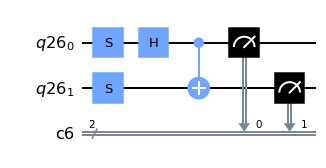

In [30]:
qiskit_circuit = qbraid_circuit.transpile('qiskit')
qiskit_circuit.draw(output='mpl')

# Run Circuits on Any Device

Let's take the original circuit above and run it on an IBM simulator, say `qasm_simulator`. We can do this using qbraid's `execute` function. This function takes two required arguments: a circuit and a device. Many device's have a unique string associated with them, and are listed in the `qbraid-sdk` reference documentation [here](). The unique string for the `qasm_simulator` is, unsurprisingly, `IBM_qasm_simulator`.

In [31]:
from qbraid import execute
qbraid_result = execute(circuit,'IBM_qasm_simulator')

IBM


qBraid has taken care of converting the circuit (originally written in `cirq`) to `qiskit` before execution. Now, we can see the results of the execution. The output is a qbraid `Result` object, which has a few standard features.

In [32]:
counts = result.get_counts()
print(counts)

{'00': 519, '01': 25, '10': 12, '11': 468}


We can also visualize the results.

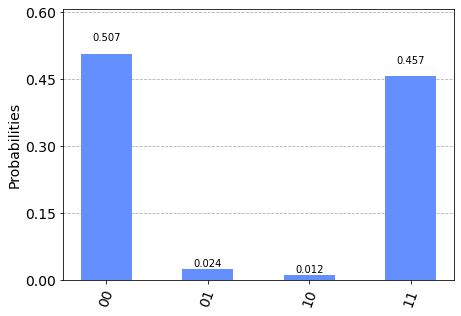

In [33]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

To access functionality specific to IBM results, we can obtain the original qiskit result object as well.

In [21]:
ibm_result = result.result
print(ibm_result.job_id)

5093a916-0c62-4ca4-b8e3-d4a86d6cdfce


# Running Any Circuit on a Custom Device

Let's take the same circuit we've written in cirq and run it on a custom noisy simulator created using `qiskit`. First, we need to create the noise model, which requires IBMQ credentials.

In [34]:
from qbraid.accounts.ibm import get_ibm_provider
provider = get_ibm_provider()
# 4e1823e5a34097a5a5034ccdd07539ec0eeb76f9417ae5ad96ec2c885215a509fd427a1cde271ba2a637559b03077b03dd3db4c0a8392dd743c24c17a9964cb9

Insert IBM Token 4e1823e5a34097a5a5034ccdd07539ec0eeb76f9417ae5ad96ec2c885215a509fd427a1cde271ba2a637559b03077b03dd3db4c0a8392dd743c24c17a9964cb9


IBMQAccountError: 'An IBM Quantum Experience account is already in use for the session.'

Now that we have a provider, we can create the noisy device simulator.

In [35]:
from qiskit.providers.aer.noise import NoiseModel

# Build noise model from backend properties
backend = provider.get_backend('ibmq_lima')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

Now, use qbraid's execute function. In addition to accepting a string identifier of many common backends, any additional `kwargs` that apply to qiskit devices can be passed along as well. In this case, we'll specify a our custom `noise_model`, and the corresponding `basis_gates` and `coupling_map`.

In [36]:
# Perform a noise simulation
from qbraid import execute
result = execute(circuit, 'IBM_qasm_simulator',
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model)
if result:
    print("Execution successful")

IBM
Execution successful


In [37]:
noisy_counts = result.get_counts()

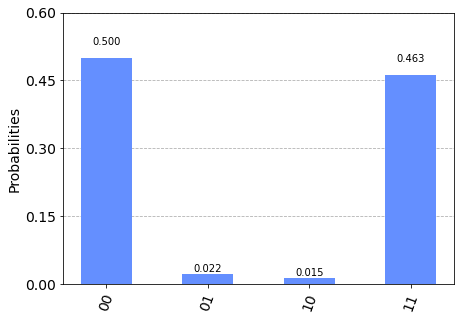

In [39]:
from qiskit.visualization import plot_histogram
plot_histogram(noisy_counts)

# Device Information

We can also use the qbraid device wrapper to get useful information about the backends.

In [ ]:
from qbraid import get_qbraid_device

dev = get_qbraid_device('IBM_igmq_lima')
print(dev.connectivity_graph)
print(dev.qubits[0].data)